Using Auto Encoders for Anomaly Detection
The idea to apply it to anomaly detection is very straightforward:

In [23]:
# read & manipulate data
import pandas as pd 
import numpy as np
import tensorflow as tf

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook

# misc
import random as rn

# load the dataset
df = pd.read_csv('Data/creditcard.csv')

# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


Renaming columns


In [24]:
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)

# print first 5 rows to get an initial impression of the data we're dealing with
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Calculated field: log10(amount) for normal distribution

In [29]:
df['log10_amount'] = np.log10(df.amount + 0.00001)
# keep the label field at the back
df = df[
    [col for col in df if col not in ['label', 'log10_amount']] + 
    ['log10_amount', 'label']
]

Consider only 1000 rows of non fraud cases¶

In [12]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

C:\Users\adity\AppData\Local\Temp\ipykernel_12332\3091554375.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)


Visualize Fraud and NonFraud Transactions

In [30]:
# manual parameter 
RATIO_TO_FRAUD = 15

# dropping redundant columns
df = df.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = df[df.label == 1]
clean = df[df.label == 0]

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions).fit_transform(features)
    
    fig, ax = plt.subplots(figsize=(8,8))
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')
    
    # plotting data
    plt.scatter(*zip(*features_embedded[np.where(labels==1)]), marker='o', color='r', s=2, alpha=0.7, label='Fraud')
    plt.scatter(*zip(*features_embedded[np.where(labels==0)]), marker='o', color='g', s=2, alpha=0.3, label='Clean')

    # displaying the plot
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show()

In [53]:
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial.png')

<IPython.core.display.Javascript object>

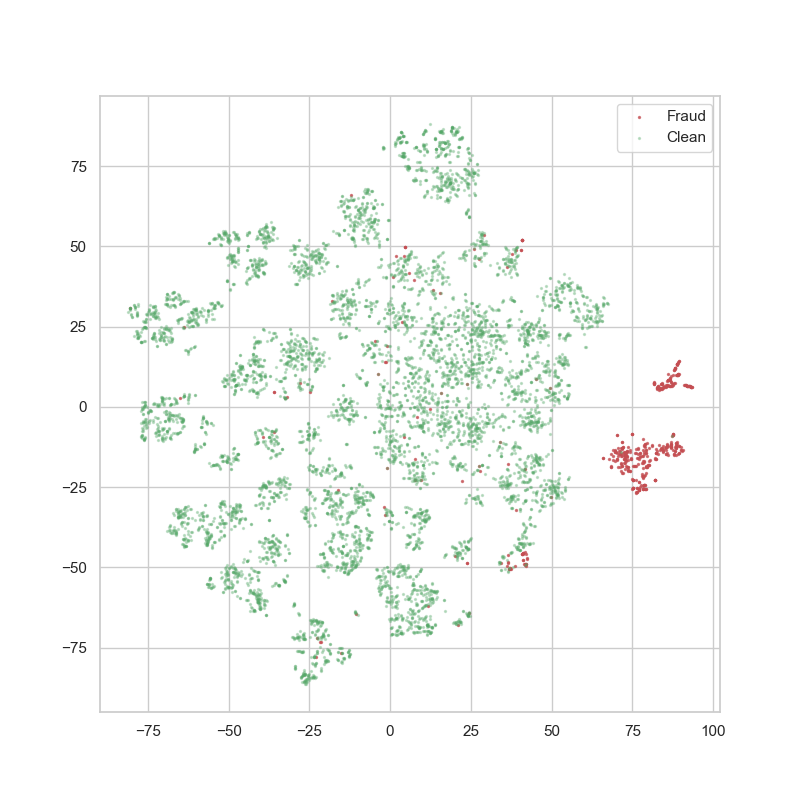

In [54]:
#displaying the tnse_initial.png
from IPython.display import Image
Image(filename='tsne_initial.png')


Train/Validate/Test split

In [55]:
print(f"""Shape of the datasets:
    clean (rows, cols) = {clean.shape}
    fraud (rows, cols) = {fraud.shape}""")

Shape of the datasets:
    clean (rows, cols) = (284315, 30)
    fraud (rows, cols) = (492, 30)


In [56]:
# shuffle our training set
clean = clean.sample(frac=1).reset_index(drop=True)

In [58]:
# training set: exlusively non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)

In [61]:
# testing set: the remaining non-fraud transactions
X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)

C:\Users\adity\AppData\Local\Temp\ipykernel_12332\1281264510.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)


In [64]:
print(f""" testing set: 0 is non-fraud and 1 is fraud

{X_test.label.value_counts()}""")

 testing set: 0 is non-fraud and 1 is fraud

0    84315
1      492
Name: label, dtype: int64


In [65]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

In [66]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (160000, 29)
    validate (rows, cols) = (40000, 29)
    holdout  (rows, cols) = (84807, 29)


Normalising & Standardising

In [70]:
# build the pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, MinMaxScaler

                    
# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

pipeline.fit(X_train)

Pipeline(steps=[('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

In [72]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)


c:\Users\adity\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


<IPython.core.display.Javascript object>

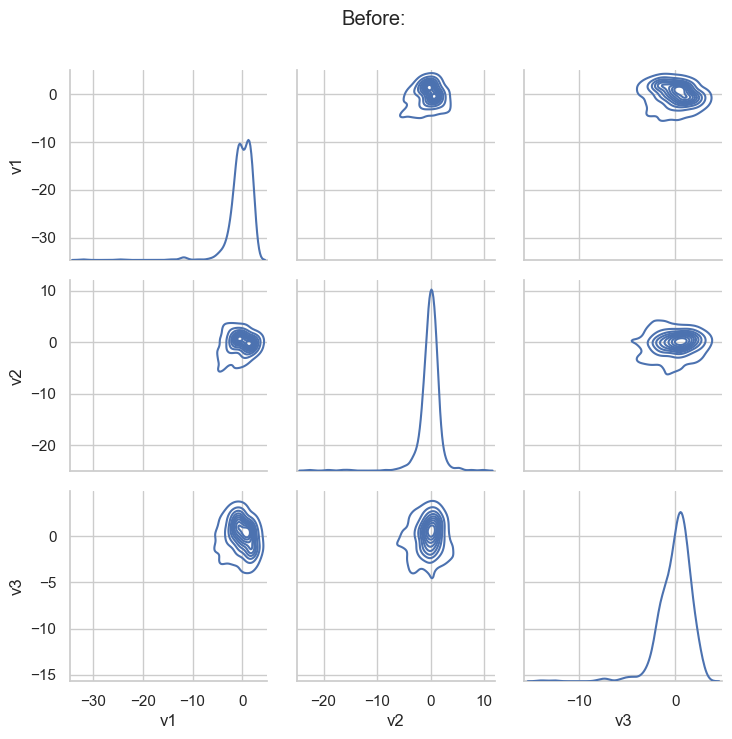

In [77]:
# Before scaling
g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);
g.savefig('before.png')

#preview the before.png
Image(filename='before.png')

<IPython.core.display.Javascript object>

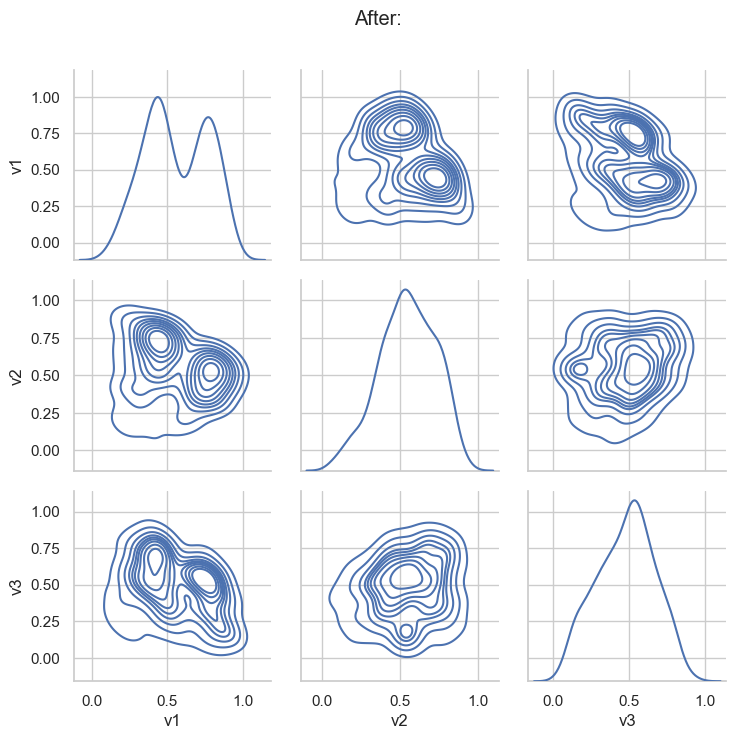

In [80]:
#after scaling
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);
g.savefig('after.png')
Image(filename='after.png')

Architecture of model

In [82]:
#dimensions 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

In [90]:
autoencoder = tf.keras.models.Sequential([
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')    
])


In [92]:
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 29)                870       
                                                                 
 dense_34 (Dense)            (None, 16)                480       
                                                                 
 dense_35 (Dense)            (None, 8)                 136       
                                                                 
 dense_36 (Dense)            (None, 4)                 36        
                                                                 
 dense_37 (Dense)            (None, 2)                 10        
                                                                 
 dense_38 (Dense)            (None, 4)                 12        
                                                                 
 dense_39 (Dense)            (None, 8)                

Callback


In [93]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

In [94]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/100
625/625 [==============================] - 3s 3ms/step - loss: 0.0346 - acc: 0.2079 - val_loss: 0.0163 - val_acc: 0.2566
Epoch 2/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0155 - acc: 0.3138 - val_loss: 0.0148 - val_acc: 0.3428
Epoch 3/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0146 - acc: 0.3428 - val_loss: 0.0145 - val_acc: 0.3405
Epoch 4/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0144 - acc: 0.3462 - val_loss: 0.0144 - val_acc: 0.3429
Epoch 5/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0142 - acc: 0.3463 - val_loss: 0.0141 - val_acc: 0.3435
Epoch 6/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0139 - acc: 0.3443 - val_loss: 0.0138 - val_acc: 0.3422
Epoch 7/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0137 - acc: 0.3526 - val_loss: 0.0136 - val_acc: 0.3572
Epoch 8/100
625/625 [==============================] - 2s 3ms/step - 

Reconstructions

In [95]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

c:\Users\adity\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


In [103]:

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

2651/2651 [==============================] - 2s 667us/step


In [124]:
# Calculate the reconstruction loss 
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)


In [125]:
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.savefig('reconstruction_loss.png')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

Setting a threshold for classification
:Unsupervised

https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm

In [127]:
THRESHOLD = 3

def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [128]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 1,605 outliers in a total of 84,807 transactions [1.89%].


Setting a threshold for classification
:Unsupervised

In [132]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

cm = confusion_matrix(y_test, outliers)

tn, fp, fn, tp = cm.flatten()

print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")


The classifications using the MAD method with threshold=3 are as follows:
[[83056  1259]
 [  146   346]]

% of transactions labeled as fraud that were correct (precision): 346/(1259+346) = 21.56%
% of fraudulent transactions were caught succesfully (recall):    346/(146+346) = 70.33%


In [134]:
clean = z_scores[y_test==0]
fraud = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("Distribution of the modified z-scores")
plt.savefig('modified_z_scores.png')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

Encoder


In [135]:
encoder = tf.keras.models.Sequential(autoencoder.layers[:5])
encoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 29)                870       
                                                                 
 dense_34 (Dense)            (None, 16)                480       
                                                                 
 dense_35 (Dense)            (None, 8)                 136       
                                                                 
 dense_36 (Dense)            (None, 4)                 36        
                                                                 
 dense_37 (Dense)            (None, 2)                 10        
                                                                 
Total params: 1,532
Trainable params: 1,532
Non-trainable params: 0
_________________________________________________________________


In [136]:
# taking all the fraud, undersampling clean
fraud = X_test_transformed[y_test==1]
clean = X_test_transformed[y_test==0][:len(fraud) * RATIO_TO_FRAUD, ]

# combining arrays & building labels
features = np.append(fraud, clean, axis=0)
labels = np.append(np.ones(len(fraud)),
                   np.zeros(len(clean)))

# getting latent space representation
latent_representation = encoder.predict(features)

print(f'Clean transactions downsampled from {len(X_test_transformed[y_test==0]):,} to {len(clean):,}.')
print('Shape of latent representation:', latent_representation.shape)

246/246 [==============================] - 0s 621us/step
Clean transactions downsampled from 84,315 to 7,380.
Shape of latent representation: (7872, 2)


In [137]:
X = latent_representation[:,0]
y = latent_representation[:,1]

# plotting
plt.subplots(figsize=(8, 8))
plt.scatter(X[labels==0], y[labels==0], s=1, c='g', alpha=0.3, label='Clean')
plt.scatter(X[labels==1], y[labels==1], s=2, c='r', alpha=0.7, label='Fraud')

# labeling
plt.legend(loc='best')
plt.title('Latent Space Representation')

# saving & displaying
plt.savefig('latent_representation_2d');
plt.show()

<IPython.core.display.Javascript object>